In [1]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models as sm
import glob
import numpy as np
from numpy import load
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras import models
import pandas as pd
import seaborn as sns

Segmentation Models: using `tf.keras` framework.


In [2]:
#setting path to training data
path = '../unet/UNET_training_data-20241014T071705Z-001/'
npz_files = glob.glob(path+'*/*.npz', recursive=True)
len(npz_files)
np.savetxt(path+"all_npz_files.csv", npz_files, delimiter =", ", fmt ='% s') #renaming path

In [3]:
filtered_datasets = [file for file in npz_files if 'marsh_vegetation' not in load(file)['classes']]
len(filtered_datasets)
np.savetxt(path+"filtered_npz_files.csv", filtered_datasets, delimiter =", ", fmt ='% s')

In [4]:
df = pd.read_csv(path+"filtered_npz_files.csv")
datasets = df.values.flatten().tolist()
datasets = [file for file in datasets if 'NAIP' not in file]

In [5]:
data = load(datasets[9]) #change 9 to however many images you have - change to landsat - has more images than sentinel
# print(list(data))
print(data['image'].shape)
print(data['label'].shape)
print(list(data['classes']))

np.any(np.isnan(data['image']))

(256, 256, 3)
(256, 256, 2)
['water', 'land', 'nodata']


False

img shape : (256, 256, 3)
label shape : (256, 256, 2)
classes : ['water' 'land' 'nodata']


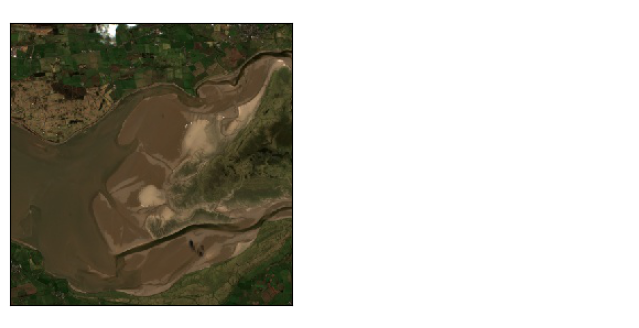

In [6]:
ds = load(datasets[1])
image = ds['image']
mask = ds['label']
classes = ds['classes']

fig, ax = plt.subplots(1, 2, figsize=(8,4))
plt.box(on=None)
plt.setp(ax, xticks=[], yticks=[])

ax[0].imshow(image)
print('img shape :', image.shape)
label = mask.astype('float')
print('label shape :', label.shape)
label[label == 0] = np.nan
print('classes :', classes)

img shape : (256, 256, 3)
label shape : (256, 256, 3)
classes : ['water' 'land' 'nodata']


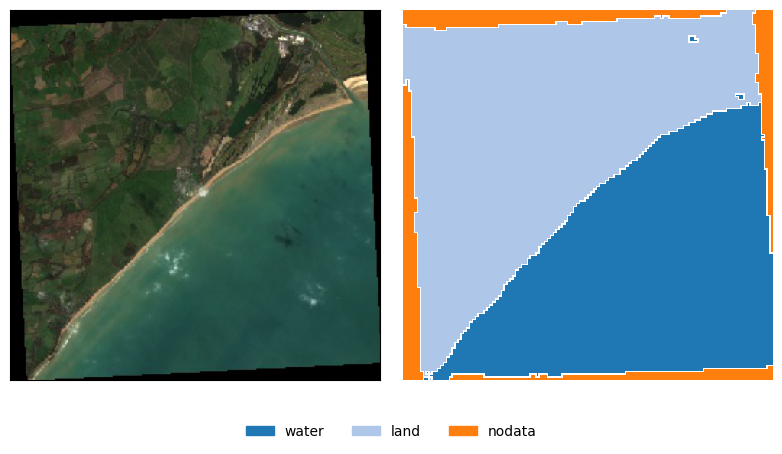

In [7]:
#@title Sanity Check
from matplotlib.colors import ListedColormap
import matplotlib.ticker as ticker
import math
import matplotlib.patches as mpatches
import random

random_number = random.randint(0, len(datasets)-1)
# random_number = 342
ds = load(datasets[random_number])
#print('data source:',datasets[random_number].split('/')[-2])
# ds = load('/content/drive/MyDrive/CoastTrain_dataset/Landsat8_11_001/ventura_2019-10-05-18-28-42_L8_rgb_ID2.npz')
image = ds['image']
mask = ds['label']
classes = ds['classes']

fig, ax = plt.subplots(1, 2, figsize=(8,4))
plt.box(on=None)
plt.setp(ax, xticks=[], yticks=[])

ax[0].imshow(image)
print('img shape :', image.shape)
label = mask.astype('float')
print('label shape :', label.shape)
label[label == 0] = np.nan
print('classes :', classes)

palette_tab20 = sns.color_palette('tab20', 11)

for i in range(label.shape[2]):
    new_colormap = ListedColormap(sns.color_palette([palette_tab20[i]]))
    ax[1].imshow(label[:, :, i], cmap=new_colormap)

# # create a patch (proxy artist) for every color
patches = [mpatches.Patch(color=palette_tab20[i],label=classes[i]) for i in range(label.shape[2])]

# put those patched as legend-handles into the legend
fig.legend(handles=patches, loc='lower center', ncols=3, bbox_to_anchor=(0.5,-0.14), frameon=False)

plt.tight_layout()
# plt.savefig('unet-output/categories_plot.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

In [15]:

import matplotlib.pyplot as plt                 # This will import plotting module
import numpy as np
import cv2

class MarchingSquares:
    def __init__(self,file,downsample_factor):
        self.downsample_factor = downsample_factor
        self._reset_state

    def _reset_state(self):
        self.image = None
        self.result_image = None
        self.threshold = None
        self.state_dict = None
        self.x_len = None
        self.y_len = None
        self.vectors = None
        self.shapes = None
        self.coastline_vector = None

    def _readfile(self):
        image_bgr = cv2.imread(self.file)
    
        #If necessary for performance speed, compress the file
        new_size = (int(image_bgr.shape[0]*self.downsample_factor),int(image_bgr.shape[1]*self.downsample_factor))
        image_resized = cv2.resize(image_bgr,new_size,interpolation =cv2.INTER_AREA)

        #For the chosen segmentation method it has been decided to segment the image
        #using the hue channel of a converted hsv image to distinguish between land and sea.

        self.image = cv2.cvtColor(image_resized, cv2.COLOR_BGR2HSV)

        return self.image
    
    def _otsu_segmentation(self):
        hue_channel = self.image[: , : , 0]
        
        self.threshold, self.result_image = cv2.threshold(
        hue_channel, 0, 1, cv2.THRESH_BINARY + cv2.THRESH_OTSU,)
        
        return self.result_image, self.threshold
   
    def _sort_key(self, point):
        return point[1]*100 +point[0]
    
    def _point_array(self):
        black = []
        white = []

        x = self.result_image.shape[0]-1
        y = self.result_image.shape[1]-1

        for i in range(x+1):
            for j in range(y+1):
                if self.result_image[i][j]==1:
                    black.append([j,x-i])
                else:
                    white.append([j,x-i])

        black = np.array(black)*2 + 1
        white = np.array(white)*2 + 1

        xblack = [point[0] for point in black]
        yblack = [point[1] for point in black]

        xwhite = [point[0] for point in white]
        ywhite = [point[1] for point in white]

        state = {tuple(point): True for point in black}
        state.update({tuple(point): False for point in white})
        sorted_dict = sorted(state.items(), key=lambda x: self._sort_key(x[0]))
        self.state_dict = dict(sorted_dict)

        self.x_len = max(xblack+xwhite)
        self.y_len = max(yblack+ywhite)

        return self.state_dict, self.x_len, self.y_len
    
    def _get_value(self, i,j,state_dict):
        A = int(state_dict[(i    , j    )])
        B = int(state_dict[(i + 2, j    )])
        C = int(state_dict[(i    , j + 2)])
        D = int(state_dict[(i + 2, j + 2)])
        return A + B*2 + C*4 + D*8
    
    def _generate_edges(self,i,j,index):
        x,y = i,j 
        vector = []
        if index == 0 or index == 15:
            return 
        elif index == 1 or index == 14:
            start = (x+1,y)
            end = (x,y+1)
            vector.append((start,end))
        elif index == 2 or index == 13:
            start = (x+1,y)
            end = (x+2,y+1)
            vector.append((start,end))
        elif index == 3 or index == 12:
            start = (x,y+1)
            end = (x+2,y+1)
            vector.append((start,end))
        elif index == 7 or index == 8:
            start = (x+2,y+1)
            end = (x+1,y+2)
            vector.append((start,end))
        elif index == 9:
            start = (x,y+1)
            end = (x+1,y+2)
            vector.append((start,end))
            start = (x+1,y)
            end = (x+2,y+1)
            vector.append((start,end))
        elif index == 5 or index == 10:
            start = (x+1,y)
            end = (x+1,y+2)
            vector.append((start,end))
        elif index == 4 or index == 11:
            start = (x,y+1)
            end = (x+1,y+2)
            vector.append((start,end))
        elif index == 6:
            start = (x+2,y+1)
            end = (x+1,y+2)
            vector.append((start,end))
            start = (x+1,y)
            end = (x,y+1)
            vector.append((start,end))
        
        return vector

    def _list_vectors(self):

        vectors = []

        for j in range(1,self.y_len,2):

            for i in range(1,self.x_len,2):

                index = self._get_value(i,j,self.state_dict)
                
                if index == 6 or index == 9:

                    double_vec = self._generate_edges(i,j,index)
                    vectors.append([double_vec[0]])
                    vectors.append([double_vec[1]])

                else:

                    vectors.append(self._generate_edges(i,j,index))

        self.vectors = [x for x in vectors if x is not None] #filtering None values
        
        return self.vectors
    
    def _vector_shapes(self):
        shapes = []
        indices_to_remove = set(range(len(self.vectors)))
        while indices_to_remove:
            shape = []
            
            # Get the first vector and extract the tuple of points
            vector = self.vectors[indices_to_remove.pop()][0] 
            start_point, end_point = vector 

            # Add the start and end points to the shape
            shape.extend([start_point, end_point])
            matched = True
            
            while matched:

                matched = False
                
                for idx in list(indices_to_remove):
                    
                    vec = self.vectors[idx][0] 

                    # Check if the vector connects to the shape
                    if vec[0] == end_point:
                        # append to end point
                        end_point = vec[1]
                        shape.append(end_point)
                        indices_to_remove.remove(idx)
                        matched = True
                        break
                    elif vec[1] == end_point:
                        # append to start point
                        end_point = vec[0]
                        shape.append(end_point)
                        indices_to_remove.remove(idx)
                        matched = True
                        break
                    elif vec[0] == start_point:
                        
                        start_point = vec[1]
                        shape.insert(0, start_point)  # Add to the beginning of the shape
                        indices_to_remove.remove(idx)
                        matched = True
                        break
                    elif vec[1] == start_point:
                        # If the start of the shape matches a reversed vector, prepend it
                        start_point = vec[0]
                        shape.insert(0, start_point)
                        indices_to_remove.remove(idx)
                        matched = True
                        break

         
            shapes.append(shape)
        
        self.shapes = sorted(shapes, key = lambda shape: len(shape), reverse = True)
        
        return self.shapes
    
    def _show_coastline(self):

        plt.figure(figsize = (10,5))
        plt.subplot(1,2,1)
        plt.title("Coastline Vector Extracted")
        for i in range(1):
            coastline_vector = self.shapes[i]
            xcoords = []
            ycoords = []
            for point in coastline_vector:
                xcoords.append(point[0])
                ycoords.append(point[1])
            plt.plot(xcoords,ycoords,linewidth = 1)    
        plt.xlim((0,self.x_len))
        plt.ylim((0,self.y_len))
        

        plt.subplot(1,2,2)
        plt.title('Original Image')
        plt.imshow(cv2.cvtColor(self.image, cv2.COLOR_HSV2RGB))
        plt.axis('off')
    
        plt.show()
        self.coastline_vector = self.shapes[0]
        
        return self.coastline_vector
    
    def run(self,file):
        self.file = file
        
        self._readfile()
        self._otsu_segmentation()
        self._point_array()
        self._list_vectors()
        self._vector_shapes()
        self._show_coastline()


UnpicklingError: Failed to interpret file 'unet-output/image.png' as a pickle

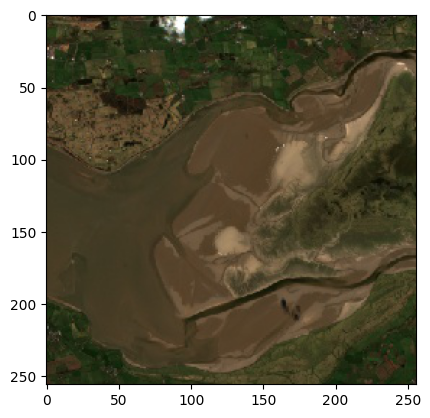